# Final Project Proposal: Proximity to Fast Food Locations as a Detriment to Citizens' Health

#### Principal Investigator: [Oliver Jiang](https://github.com/jiangoliver) <br> Email: oliver.jiang@stern.nyu.edu

On a primary basis, this project will investigate if indicators of unhealthy living (obesity, diabetes, cardiac illness rates) generally correlate with a county's concentration of fast-food restaurants on a nationwide level. A thorough secondary consideration will determine the influence, on the same unhealthy indicators, of other factors, such as income, access to grocery stores and taxes on unhealthy products. 

This project will be broken down into three sections. 
  * The primary objective is to determine whether the concentration of fast-food restaurants are correlated with obesity, diabetes and cardiac illness rates. After scatter plots of unhealthy indices and concentration are created, it would make sense to create nationwide county maps of the individual factors. 
 <br>
 <br>
  * Then, aggregate all county-level data and run a correlation between a manufactured 'healthy-living index' and proximity to fast food restaurants. So each state would have a correlation number between 0 and 1. This can be mapped out using a heat map to see if there is any link on the nationwide level. 
  <br>
  <br>
  * Finally, it would be interesting to look at how the above secondary factors affect the healthy-living index- while the project does not require a multi-variate analysis, I hypothesize that income and price of healthy foods play the largest role in for example, obesity rates. 

In [2]:
import fiona

In [3]:
# import the essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import the mapping packages
from IPython.display import display, Image
import geopandas as gpd
from shapely.geometry import Point, Polygon

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [4]:
import os

In [5]:
cwd = os.getcwd()

In [6]:
file_path = cwd + '\\Project\\'

In [7]:
# data provided by USDA's Economic Research Service. Last updated in September 2017.

df_food = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'RESTAURANTS')

In [8]:
# we have county level food service information. I also want the population estimate that has been included in the dataset.

df_pop = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'Supplemental Data - County')

In [9]:
# and import the diabetic and obesity rates per county.

df_health = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'HEALTH')

In [10]:
df_pop.head()

,FIPS,State,County,2010 Census Population,"Population Estimate, 2011","Population Estimate, 2012","Population Estimate, 2013","Population Estimate, 2014","Population Estimate, 2015","Population Estimate, 2016"
0,1001,Alabama,Autauga,"54,571","55,255","55,027","54,792","54,977","55,035","55,416"
1,1003,Alabama,Baldwin,"182,265","186,653","190,403","195,147","199,745","203,690","208,563"
2,1005,Alabama,Barbour,"27,457","27,326","27,132","26,938","26,763","26,270","25,965"
3,1007,Alabama,Bibb,"22,915","22,736","22,645","22,501","22,511","22,561","22,643"
4,1009,Alabama,Blount,"57,322","57,707","57,772","57,746","57,621","57,676","57,704"


In [11]:
# I'm going to import another dataset from Kaggle that has logged the exact location of 10,000 fast food restaurants

df_locations = pd.read_csv(file_path + 'fast_food_locations.csv')

In [12]:
df_locations.head(3)

,id,dateAdded,dateUpdated,address,categories,city,country,keys,latitude,longitude,name,postalCode,province,sourceURLs,websites
0,AVwcmSyZIN2L1WUfmxyw,2015-10-19T23:47:58Z,2018-06-26T03:00:14Z,800 N Canal Blvd,American Restaurant and Fast Food Restaurant,Thibodaux,US,us/la/thibodaux/800ncanalblvd/1780593795,29.814697,-90.814742,SONIC Drive In,70301,LA,https://foursquare.com/v/sonic-drive-in/4b7361...,https://locations.sonicdrivein.com/la/thibodau...
1,AVwcmSyZIN2L1WUfmxyw,2015-10-19T23:47:58Z,2018-06-26T03:00:14Z,800 N Canal Blvd,Fast Food Restaurants,Thibodaux,US,us/la/thibodaux/800ncanalblvd/1780593795,29.814697,-90.814742,SONIC Drive In,70301,LA,https://foursquare.com/v/sonic-drive-in/4b7361...,https://locations.sonicdrivein.com/la/thibodau...
2,AVwcopQoByjofQCxgfVa,2016-03-29T05:06:36Z,2018-06-26T02:59:52Z,206 Wears Valley Rd,Fast Food Restaurant,Pigeon Forge,US,us/tn/pigeonforge/206wearsvalleyrd/-864103396,35.803788,-83.580553,Taco Bell,37863,TN,https://www.yellowpages.com/pigeon-forge-tn/mi...,"http://www.tacobell.com,https://locations.taco..."


In [13]:
# median household income and other socioeconomic data

df_income = pd.read_excel(file_path + 'food_atlas.xls', sheet_name = 'SOCIOECONOMIC')

## 0. Clean up the data

In [14]:
# Clean up the pop data first

df_pop = df_pop.drop(['Population Estimate, 2011', 'Population Estimate, 2012',
                      'Population Estimate, 2013', 'Population Estimate, 2014',
                      'Population Estimate, 2015'], axis = 1)
        
df_pop.rename(columns = {'FIPS ': 'FIPS', '2010 Census Population': 'pop_census', 'Population Estimate, 2016': 'pop_16' }
              , inplace = True)

df_pop = df_pop.set_index('FIPS')

In [15]:
# Clean up health data

df_health = df_health.drop(['RECFAC09', 'RECFAC14', 
                            'PCH_RECFAC_09_14', 'RECFACPTH09', 
                            'RECFACPTH14', 'PCH_RECFACPTH_09_14'], axis = 1)

df_health = df_health.rename(index = str , columns = ({'PCT_DIABETES_ADULTS08':'diabetes_08', 
                                                       'PCT_DIABETES_ADULTS13': 'diabetes_13', 
                                                       'PCT_OBESE_ADULTS08': 'obese_08', 
                                                       'PCT_OBESE_ADULTS13': 'obese_13',
                                                       'PCT_HSPA15': 'hsactive_15', 
                                                      }))

df_health.set_index('FIPS', inplace = True)

In [16]:
# Clean up restaurants data

df_food = df_food.drop(['PCH_FFR_09_14', 'FFRPTH09', 
                        'FFRPTH14', 'PCH_FFRPTH_09_14',
                        'PCH_FSR_09_14', 'FSRPTH09', 
                        'FSRPTH14', 'PCH_FSRPTH_09_14'], axis = 1)

df_food = df_food.rename(index = str, columns = {'FFR09':'fast_09',
                                       'FFR14': 'fast_14', 
                                       'FSR09': 'rest_09', 
                                       'FSR14': 'rest_14', 
                                       'PC_FFRSALES07': 'fastspend_09', 
                                       'PC_FFRSALES12': 'fastspend_12', 
                                       'PC_FSRSALES07': 'restspend_09', 
                                       'PC_FSRSALES12': 'restspend_12'})

df_food.set_index('FIPS', inplace = True)

In [17]:
# Clean up the income data

df_income = df_income.drop(['State', 'County', 'PCT_NHWHITE10', 'PCT_NHBLACK10',
                            'PCT_HISP10', 'PCT_NHASIAN10', 'PCT_NHNA10', 'PCT_NHPI10',
                            'PCT_65OLDER10', 'PCT_18YOUNGER10','PERPOV10','PERCHLDPOV10', 
                            'METRO13', 'POPLOSS10'], axis = 1)

df_income = df_income.rename(index = str, columns = {'MEDHHINC15': 'income',
                                         'POVRATE15': 'poverty_rate', 
                                         'CHILDPOVRATE15': 'child_poverty'})

In [18]:
# Merge the datasets on FIPS

df = pd.merge(pd.merge(df_pop, df_food, on = 'FIPS'), df_health, on = 'FIPS')

df = df.drop(['State_y', 'County_y', 'State_x', 'County_x'], axis = 1)

df = pd.merge(df, df_income, on =  'FIPS')

In [19]:
df.head()

,FIPS,pop_census,pop_16,fast_09,fast_14,rest_09,rest_14,fastspend_09,fastspend_12,restspend_09,...,State,County,diabetes_08,diabetes_13,obese_08,obese_13,hsactive_15,income,poverty_rate,child_poverty
0,1001,"54,571","55,416",30,36,34,29,649.511367,674.80272,484.381507,...,AL,Autauga,11.4,13.0,31.5,34.1,25.4,56580.0,12.7,18.8
1,1003,"182,265","208,563",112,132,202,221,649.511367,674.80272,484.381507,...,AL,Baldwin,9.8,10.4,26.2,27.4,25.4,52387.0,12.9,19.6
2,1005,"27,457","25,965",21,22,12,15,649.511367,674.80272,484.381507,...,AL,Barbour,13.6,18.4,37.6,44.4,25.4,31433.0,32.0,45.2
3,1007,"22,915","22,643",7,5,6,5,649.511367,674.80272,484.381507,...,AL,Bibb,11.1,14.8,32.3,40.3,25.4,40767.0,22.2,29.3
4,1009,"57,322","57,704",24,21,19,15,649.511367,674.80272,484.381507,...,AL,Blount,11.4,14.1,31.9,34.6,25.4,50487.0,14.7,22.2


In [20]:
df.shape

(3140, 21)

In [196]:
df['FIPS']=df['FIPS'].apply(lambda x: '{0:0>5}'.format(x))

In [199]:
df = df.set_index('FIPS')

It looks like this data is collected every 5 years. So we can at least investigate the change in a few variables.
<br> <br>
This merged dataset contains all the important variables we need, primarily. However, I will read in other datasets that might add color to our narrative throughout. 

# 1. Big picture visualization

Here I'm looking to make sure geopandas and plotly works, and visualize some of the hypotheses that I have had about the project.

In [177]:
countyshape = gpd.read_file(file_path + '\\tl_2018_us_county.shx')

In [192]:
countyshape = countyshape.rename(index = str, columns = {'GEOID':'FIPS'})

In [239]:
geo_df = pd.merge(countyshape, df, on = 'FIPS')

In [375]:
DS_states = ['GA', 'AL', 'SC', 'MS', 'LA', 'TX']

deep_south = geo_df[geo_df.State.isin(DS_states)]

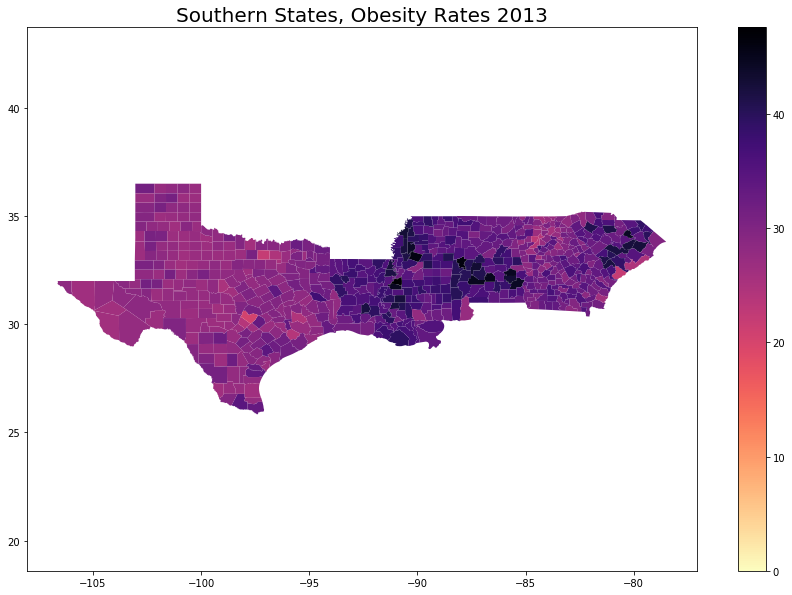

In [379]:
fig, ax = plt.subplots(figsize = (15,10))

deep_south.plot(ax = ax,
              edgecolor = '', 
              cmap = 'magma_r',
              vmin = 0, vmax = geo_df.obese_13.max(),
              legend = True,
              column = 'obese_13')


ax.set_title('Southern States, Obesity Rates 2013', fontsize = 20)

plt.axis('equal')
plt.show()

In [346]:
NE_states = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']

new_england = geo_df[geo_df.State.isin(NE_states)]

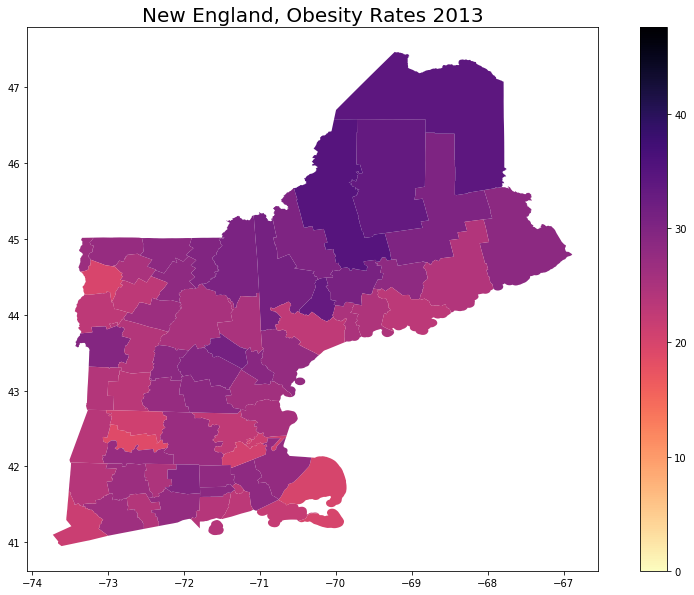

In [361]:
fig, ax = plt.subplots(figsize = (15,10))

new_england.plot(ax = ax,
              edgecolor = '', 
              cmap = 'magma_r',
              vmin = 0, vmax = geo_df.obese_13.max(),
              legend = True,
              column = 'obese_13')

ax.set_title('New England, Obesity Rates 2013', fontsize = 20)

plt.show()

Text(0.5, 1.0, 'Southern States, Income and Obesity')

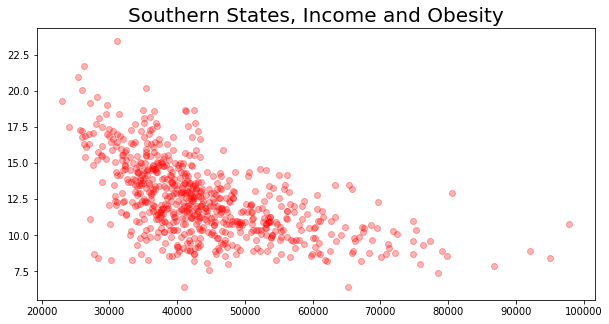

In [391]:
# Hypothesis: Clear negative relationships between household income and diabetes rate

fig, ax = plt.subplots(figsize = (10,5))

ax.scatter(deep_south.income, deep_south.diabetes_13, c = 'r', alpha = 0.3)
ax.set_title('Southern States, Income and Obesity', fontsize = 20)

In [396]:
# And maybe look at the data aggregated by state

grouped = df.groupby(['State']).mean()

grouped = grouped.sort_values(by = ['fastspend_12'], ascending = False)

<BarContainer object of 51 artists>

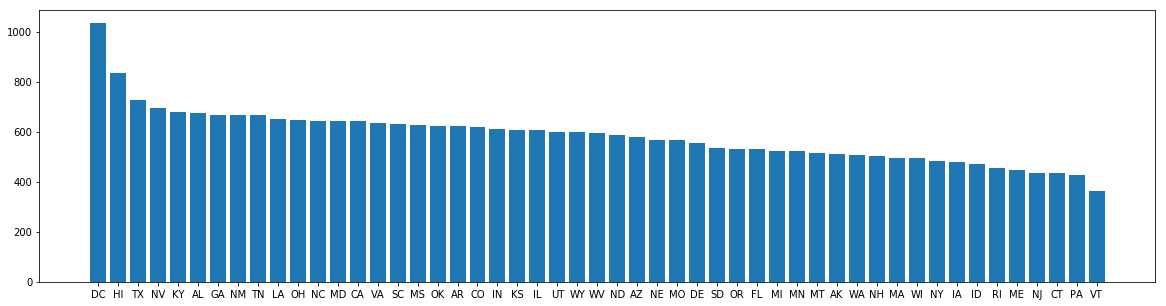

In [403]:
fig, ax = plt.subplots(figsize = (20,5))

ax.bar(grouped.index, grouped.fastspend_12)

In [452]:
# Purchasing power differs from state to state, of course. So we normalize based on the BEA's regional price parity index

rpp_df = pd.read_excel(file_path + '\\rpp0518.xlsx', sheet_name = 'Table 3')

In [453]:
rpp_df.columns = ['state_full', 'all_items', 'goods', 'rent', 'other']

In [454]:
rpp_df = rpp_df[4:55]

In [463]:
# They say 'taxation without representation' but I have included D.C. in my analysis as well

states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "DC", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

rpp_df['State'] = states

In [464]:
grouped = grouped.merge(rpp_df, on = 'State')

In [479]:
grouped['real_fastspend_12'] = grouped.fastspend_12/grouped.goods*100
grouped = grouped.sort_values(by = ['real_fastspend_12'])

<BarContainer object of 51 artists>

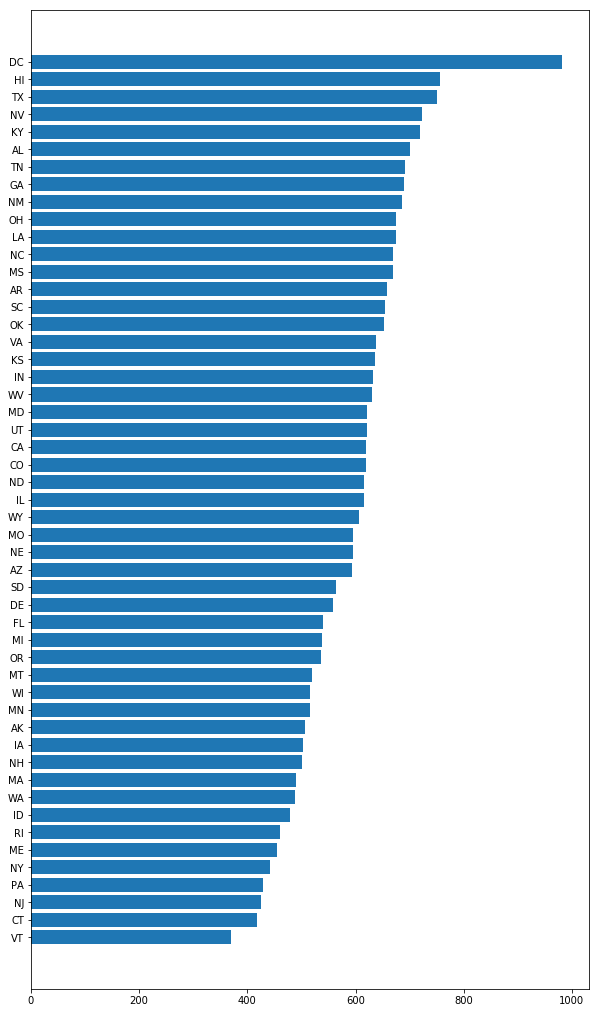

In [484]:
fig, ax = plt.subplots(figsize = (10,18))

ax.barh(grouped.index, grouped.real_fastspend_12)

In [76]:
# Here I am looking at New England as a template for visualization

# While the default Geopandas package is useful, plotly allows you to hover over the data - it is slightly interactive!
import plotly
import plotly.graph_objs as go
import plotly.plotly as py

plotly.tools.set_credentials_file(username = 'theoliverjiang', api_key = 'xCS2GLyeTVC66ds5D21H')


NE_states = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT']
test_NE = df[df['State'].isin(NE_states)]

In [151]:
endpts = list(np.linspace(0, 100000, 11))

fig = ff.create_choropleth(
    fips = test_NE.FIPS.tolist(), values = test_NE.income.tolist(),
    binning_endpoints=endpts,
    scope = NE_states, county_outline ={'color': 'rgb(255,255,255)', 'width': 0.3},
    legend_title = 'Median Income, 2015'
)

fig['layout']['legend'].update({'x': 0 })
fig['layout']['annotations'][0].update({'x': -0.12, 'xanchor':'left'})

py.iplot(fig, filename = 'choropleth_new_england')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~theoliverjiang/0 or inside your plot.ly account where it is named 'choropleth_new_england'


In [108]:
# the colorlover package allows me to pick my own colors, which is nice

import colorlover as cl
from IPython.display import HTML
HTML(cl.to_html(cl.flipper()['seq']['9']))

In [109]:
deep_south_states = ['GA', 'AL', 'SC', 'MS', 'LA']
test_deep_south = df[df['State'].isin(deep_south_states)]

In [110]:
scl = cl.scales['9']['seq']['YlOrRd']

endpts = list(np.linspace(0, 50, len(scl) - 3))

fig = ff.create_choropleth(
    fips = test_deep_south.FIPS.tolist(), values = test_deep_south.obese_13.tolist(),
    colorscale = scl,
    binning_endpoints=endpts,
    scope = deep_south_states, county_outline ={'color': 'rgb(255,255,255)', 'width': 0.3},
    legend_title = 'Obesity Rates, 2013'
)

fig['layout']['legend'].update({'x': 0})
fig['layout']['annotations'][0].update({'x': -0.12, 'xanchor':'left'})

py.iplot(fig, filename = 'choropleth_deep_south')

In [163]:
trace = go.Scatter(
    x = df.income, y = df.obese_13,
    text = df.County,
    marker = dict(opacity = 0.4),
    textposition = 'top center',
    mode = 'markers')

data = [trace]
py.iplot(data)